In [1]:
# Plenty libraries added, but we are going to use most of them 
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.metrics import make_scorer, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from keras import models, layers, optimizers, regularizers
from quilt.data.ResidentMario import missingno_data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l1,l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from pandas import get_dummies
from catboost import Pool, cv
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import datetime
import warnings
import sklearn
import scipy
import numpy
import time
import math
import json
import sys
import csv
import os


Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


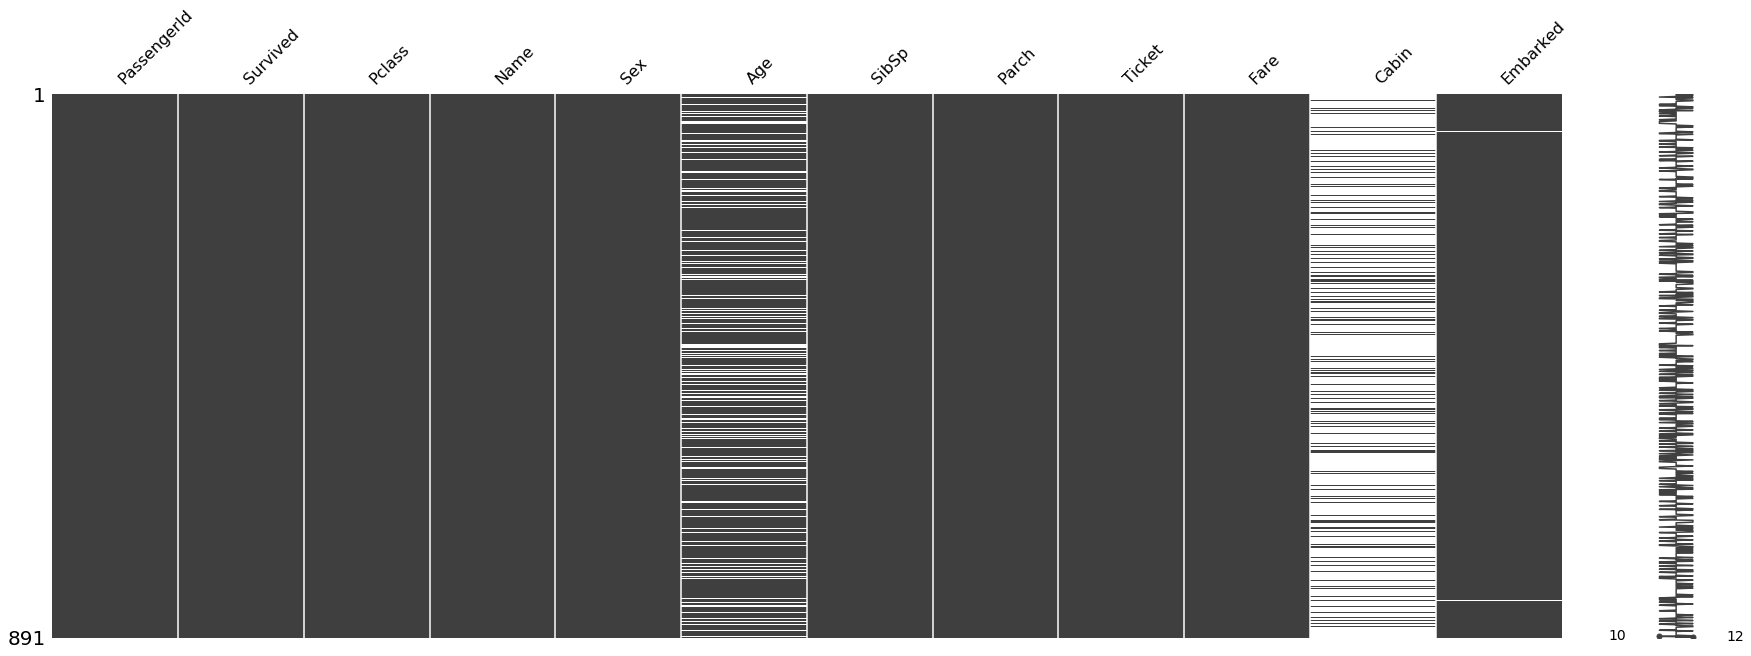

In [4]:
import missingno as msno
msno.matrix(train, figsize = (30,10))

In [5]:
print("check null values for training data: \n \n", train.isna().sum())
print("*********************************")
print("check null values for test data: \n \n", test.isna().sum())

check null values for training data: 
 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
*********************************
check null values for test data: 
 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# here the code to replace the Age where is null with mean
# here the code to replace the Fare where is null with mean

ageMean =  math.floor(train['Age'].mean())
ageMeanT =  math.floor(test['Age'].mean())
train['Age'] = train['Age'].fillna(ageMean)
test['Age'] = test['Age'].fillna(ageMeanT)

FareMeanT =  math.floor(test['Fare'].mean())
test['Fare'] = test['Fare'].fillna(FareMeanT)            

In [7]:
# here the code to replace the Cabin where is null with mode
first = train['Cabin'].mode()
first = first [0]
firstT = test['Cabin'].mode()
firstT = firstT[0]
test['Cabin'] = test['Cabin'].fillna(firstT)
train['Cabin'] = train['Cabin'].fillna(first)

In [8]:
# here the code to replace the Embarked where is null with mode
EmbarkedMax = train['Embarked'].mode()
train['Embarked'] = train['Embarked'].fillna(EmbarkedMax[0])

In [9]:
bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
categories = pd.cut(train.Age, bins, labels=group_names)
train.Age = categories

Text(0.5, 1.0, 'Age:Survived vs Dead')

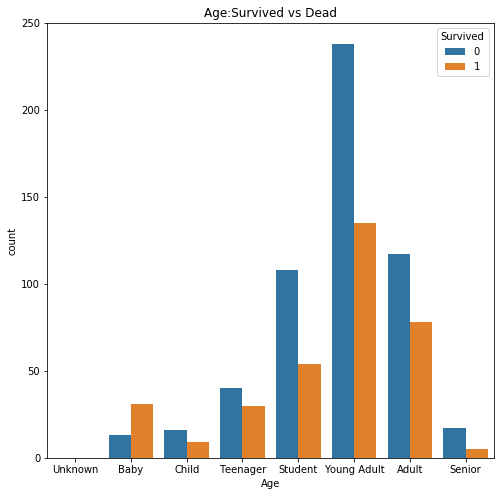

In [10]:
plt.subplots(figsize=(8,8))
ax =sns.countplot('Age',hue='Survived',data=train)
ax.set_title('Age:Survived vs Dead')

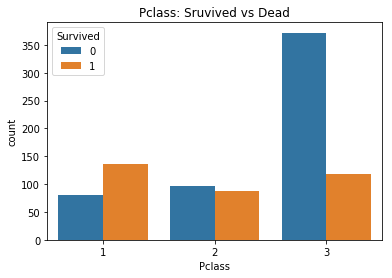

In [11]:
sns.countplot('Pclass', hue='Survived', data=train)
plt.title('Pclass: Sruvived vs Dead')
plt.show()

In [12]:
X = train.drop(['PassengerId'], axis=1)

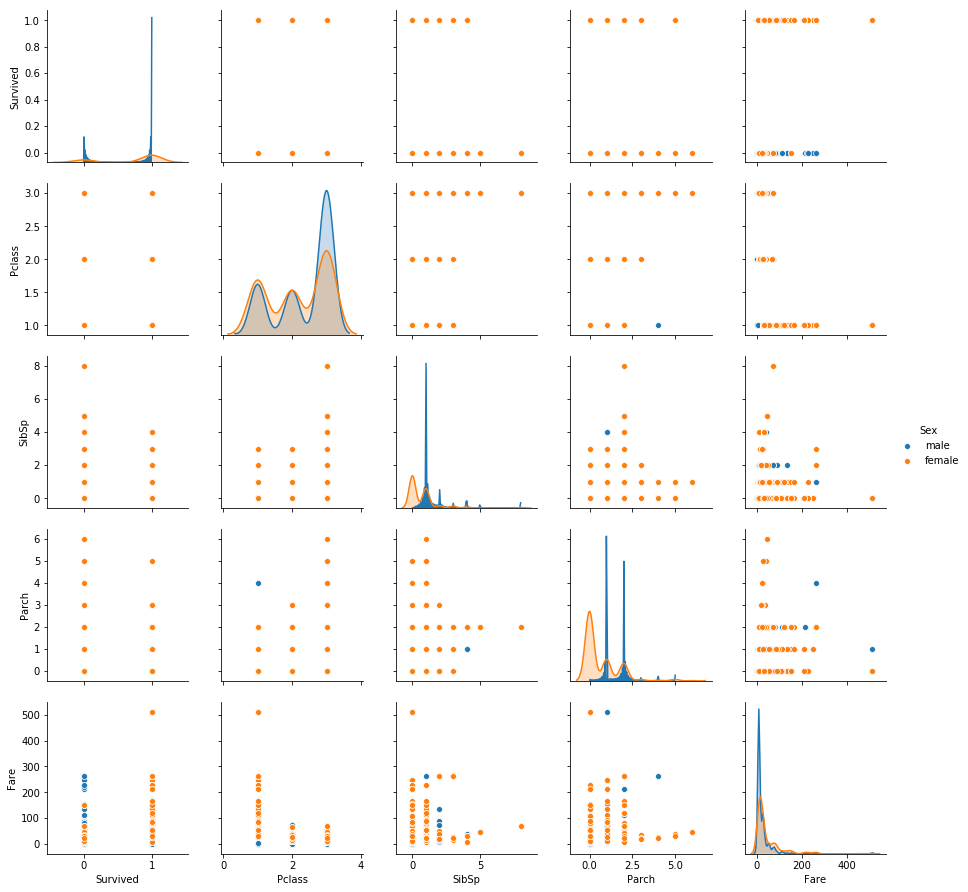

In [13]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
sns.pairplot(X, hue="Sex");

Text(0.5, 1.0, 'SibSp:Survived vs Dead')

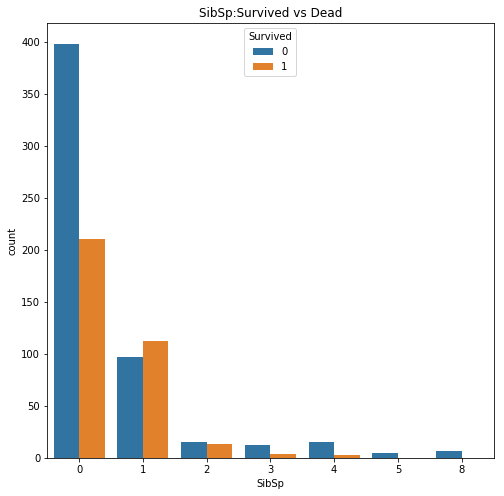

In [14]:
plt.subplots(figsize=(8,8))
ax =sns.countplot('SibSp',hue='Survived',data=train)
ax.set_title('SibSp:Survived vs Dead')

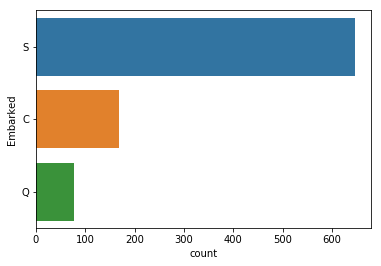

In [15]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

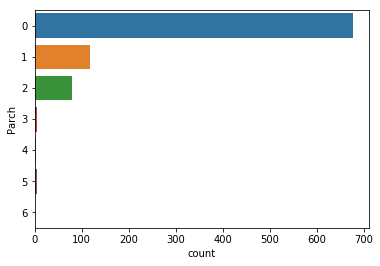

In [16]:
# What do the counts look like?
sns.countplot(y='Parch', data=train);

In [17]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [18]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

ageMean =  math.floor(train['Age'].mean())
ageMeanT =  math.floor(test['Age'].mean())
train['Age'] = train['Age'].fillna(ageMean)
test['Age'] = test['Age'].fillna(ageMeanT)

first = train['Cabin'].mode()
first = first [0]
firstT = test['Cabin'].mode()
firstT = firstT[0]
test['Cabin'] = test['Cabin'].fillna(firstT)
train['Cabin'] = train['Cabin'].fillna(first)

# here the code to replace the Embarked where is null with mode
EmbarkedMax = train['Embarked'].mode()
train['Embarked'] = train['Embarked'].fillna(EmbarkedMax[0])


df_train_T = train;

df_train_T = transform_features(df_train_T);

df_test_T = test;
df_test_T = transform_features(df_test_T);

In [19]:
df_train_T.head(n=5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,B,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,B,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,B,"Allen,",Mr.


In [20]:
df_test_T.head(n=5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,male,Young Adult,0,0,1_quartile,B,"Kelly,",Mr.
1,893,3,female,Adult,1,0,1_quartile,B,"Wilkes,",Mrs.
2,894,2,male,Senior,0,0,2_quartile,B,"Myles,",Mr.
3,895,3,male,Young Adult,0,0,2_quartile,B,"Wirz,",Mr.
4,896,3,female,Student,1,1,2_quartile,B,"Hirvonen,",Mrs.


In [21]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

In [22]:
train_encode = df_train_T.copy();
test_encode = df_test_T.copy();
# train_encode.head()
train_encode, test_encode = encode_features(train_encode, test_encode)
train_encode.head(n=5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,1,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,6,0,0,0,1,329,16
3,4,1,1,0,6,1,0,3,2,267,20
4,5,0,3,1,6,0,0,1,1,15,19


In [23]:
test_encode.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,6,0,0,0,1,401,19
1,893,3,0,0,1,0,0,1,843,20
2,894,2,1,3,0,0,1,1,552,19
3,895,3,1,6,0,0,1,1,851,19
4,896,3,0,4,1,1,1,1,342,20


In [24]:
pd.set_option('display.max_columns', 500)
test_encode_one_hot_cols = test_encode.copy()
one_hot_cols = test_encode_one_hot_cols.columns.tolist()
one_hot_cols = [e for e in one_hot_cols if e not in ('PassengerId', 'Survived' , 'Lname', 'NamePrefix')]

test_encode_one_hot_cols = test_encode_one_hot_cols[one_hot_cols] 
test_encode_one_hot_cols = pd.get_dummies(test_encode_one_hot_cols, columns=one_hot_cols)

# test_encode_one_hot_cols['PassengerId'] = test_encode['PassengerId']
test_encode_one_hot_cols.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6
0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [25]:
train_encode_one_hot_cols = train_encode.copy()
one_hot_cols = train_encode_one_hot_cols.columns.tolist()
one_hot_cols = [e for e in one_hot_cols if e not in ('PassengerId', 'Survived' , 'Lname', 'NamePrefix')]

train_encode_one_hot_cols = train_encode_one_hot_cols[one_hot_cols] 
train_encode_one_hot_cols = pd.get_dummies(train_encode_one_hot_cols, columns=one_hot_cols)

# train_encode_one_hot_cols= train_encode_one_hot_cols.drop(columns='Cabin_7')
train_encode_one_hot_cols.head()


,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7
0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [26]:
train_encode_one_hot_cols.shape

(891, 39)

In [27]:
test_encode_one_hot_cols.shape

(418, 39)

In [28]:
x_all = train_encode_one_hot_cols.copy()
y_all = train['Survived']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3, random_state=123)

In [30]:
# X_test.head()

In [31]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    y_predict_new = np.array(y_predict,dtype='int64')
    
    precision_score_test = precision_score(y_test,y_predict_new)
    
    
    acc_train = round(model.score(X_train, y_train) * 100, 2)
    
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    
    # Cross Validation 
    test_pred = model_selection.cross_val_predict(algo, 
                                                  X_test, 
                                                  y_test, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv_train = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    # Cross-validation accuracy metric
    acc_cv_test = round(metrics.accuracy_score(y_test, test_pred) * 100, 2)
    
    
    
    return train_pred, acc_train, acc_cv_train, test_pred, acc_cv_test ,precision_score_test

# Logistic Regression

In [32]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log_train, acc_cv_log_train, test_pred_log, acc_cv_test_lr,precision_score_test = fit_ml_algo(LogisticRegression(),X_train, y_train,X_test, y_test,10)
log_time = (time.time() - start_time)

print("Accuracy Train: %s" % acc_log_train, '\n')
print("Accuracy CV Train 10-Fold: %s" % acc_cv_log_train, '\n')


print("Precision Score Test: %s" % precision_score_test, '\n')
print("Accuracy CV Test 10-Fold: %s" % acc_cv_test_lr, '\n')



print("Running Time: %s" % datetime.timedelta(seconds=log_time))

C:\Users\mfarhadloo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Train: 82.83 

Accuracy CV Train 10-Fold: 80.1 

Precision Score Test: 0.74 

Accuracy CV Test 10-Fold: 79.1 

Running Time: 0:00:03.767831


# KNeighborsClassifier

In [33]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log_train, acc_cv_log_train, test_pred_log, acc_cv_test_KNN,precision_score_test = fit_ml_algo(KNeighborsClassifier(),X_train, y_train,X_test, y_test,10)
log_time = (time.time() - start_time)

print("Accuracy Train: %s" % acc_log_train, '\n')
print("Accuracy CV Train 10-Fold: %s" % acc_cv_log_train, '\n')


print("Precision Score Test: %s" % precision_score_test, '\n')
print("Accuracy CV Test 10-Fold: %s" % acc_cv_test_KNN, '\n')



print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy Train: 82.02 

Accuracy CV Train 10-Fold: 80.1 

Precision Score Test: 0.6666666666666666 

Accuracy CV Test 10-Fold: 81.34 

Running Time: 0:00:00.126927


# LinearSVC

In [34]:
# Linear SVC
start_time = time.time()
train_pred_log, acc_log_train, acc_cv_log_train, test_pred_log, acc_cv_linear_svc,precision_score_test = fit_ml_algo(LinearSVC(),X_train, y_train,X_test, y_test,10)
log_time = (time.time() - start_time)

print("Accuracy Train: %s" % acc_log_train, '\n')
print("Accuracy CV Train 10-Fold: %s" % acc_cv_log_train, '\n')
print("Precision Score Test: %s" % precision_score_test, '\n')
print("Accuracy CV Test 10-Fold: %s" % acc_cv_linear_svc, '\n')



print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy Train: 82.83 

Accuracy CV Train 10-Fold: 80.26 

Precision Score Test: 0.7525773195876289 

Accuracy CV Test 10-Fold: 78.73 

Running Time: 0:00:00.088948


# SGDClassifier

In [35]:
# SGDClassifier
start_time = time.time()
train_pred_log, acc_log_train, acc_cv_log_train, test_pred_log, acc_cv_sgd,precision_score_test = fit_ml_algo(SGDClassifier(),X_train, y_train,X_test, y_test,10)
log_time = (time.time() - start_time)

print("Accuracy Train: %s" % acc_log_train, '\n')
print("Accuracy CV Train 10-Fold: %s" % acc_cv_log_train, '\n')
print("Precision Score Test: %s" % precision_score_test, '\n')
print("Accuracy CV Test 10-Fold: %s" % acc_cv_sgd, '\n')



print("Running Time: %s" % datetime.timedelta(seconds=log_time))

C:\Users\mfarhadloo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy Train: 77.85 

Accuracy CV Train 10-Fold: 72.07 

Precision Score Test: 0.723404255319149 

Accuracy CV Test 10-Fold: 69.03 

Running Time: 0:00:00.077955


# DecisionTreeClassifier

In [36]:
# SGDClassifier
start_time = time.time()
train_pred_log, acc_log_train, acc_cv_log_train, test_pred_log, acc_cv_dt,precision_score_test = fit_ml_algo(DecisionTreeClassifier(),X_train, y_train,X_test, y_test,10)
log_time = (time.time() - start_time)

print("Accuracy Train: %s" % acc_log_train, '\n')
print("Accuracy CV Train 10-Fold: %s" % acc_cv_log_train, '\n')
print("Precision Score Test: %s" % precision_score_test, '\n')
print("Accuracy CV Test 10-Fold: %s" % acc_cv_dt, '\n')



print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy Train: 90.37 

Accuracy CV Train 10-Fold: 78.97 

Precision Score Test: 0.7241379310344828 

Accuracy CV Test 10-Fold: 77.24 

Running Time: 0:00:00.092946


# GradientBoostingClassifier

In [37]:
# SGDClassifier
start_time = time.time()
train_pred_log, acc_log_train, acc_cv_log_train, test_pred_log, acc_cv_gbt,precision_score_test = fit_ml_algo(GradientBoostingClassifier(),X_train, y_train,X_test, y_test,10)
log_time = (time.time() - start_time)

print("Accuracy Train: %s" % acc_log_train, '\n')
print("Accuracy CV Train 10-Fold: %s" % acc_cv_log_train, '\n')
print("Precision Score Test: %s" % precision_score_test, '\n')
print("Accuracy CV Test 10-Fold: %s" % acc_cv_gbt, '\n')


print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy Train: 87.96 

Accuracy CV Train 10-Fold: 82.5 

Precision Score Test: 0.8068181818181818 

Accuracy CV Test 10-Fold: 79.48 

Running Time: 0:00:00.479724


# CatBoostClassifier

In [38]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, y_train,cat_features)

In [39]:
def acuuracyRate(model,x_test):
    prediction = model.predict(X_test, prediction_type='Class', ntree_start=0, ntree_end=0, thread_count=-1, verbose=None)
    preds = np.array(prediction,dtype='int64')
    acc = accuracy_score(y_test,preds)
    return acc    

# AUC

In [40]:
# CatBoost model definition
catboost_modelAUC = CatBoostClassifier(iterations=1000,eval_metric='AUC',loss_function='Logloss',random_seed=42)
#now just to make the model to fit the data
catboost_modelAUC.fit(X_train,y_train,cat_features=cat_features,eval_set=(X_test,y_test), plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.074246
0:	test: 0.8266807	best: 0.8266807 (0)	total: 89.9ms	remaining: 1m 29s
1:	test: 0.8609244	best: 0.8609244 (1)	total: 125ms	remaining: 1m 2s
2:	test: 0.8623349	best: 0.8623349 (2)	total: 156ms	remaining: 52s
3:	test: 0.8685774	best: 0.8685774 (3)	total: 191ms	remaining: 47.5s
4:	test: 0.8679172	best: 0.8685774 (3)	total: 215ms	remaining: 42.7s
5:	test: 0.8715486	best: 0.8715486 (5)	total: 248ms	remaining: 41.1s
6:	test: 0.8693277	best: 0.8715486 (5)	total: 308ms	remaining: 43.7s
7:	test: 0.8673469	best: 0.8715486 (5)	total: 334ms	remaining: 41.5s
8:	test: 0.8747899	best: 0.8747899 (8)	total: 387ms	remaining: 42.6s
9:	test: 0.8755702	best: 0.8755702 (9)	total: 423ms	remaining: 41.8s
10:	test: 0.8773709	best: 0.8773709 (10)	total: 466ms	remaining: 41.9s
11:	test: 0.8757203	best: 0.8773709 (10)	total: 505ms	remaining: 41.5s
12:	test: 0.8753601	best: 0.8773709 (10)	total: 542ms	remaining: 41.2s
13:	test: 0.8767407	best: 0.8773709 (10)	total: 580ms	remaining: 40

116:	test: 0.8838235	best: 0.8855042 (42)	total: 3.88s	remaining: 29.3s
117:	test: 0.8854442	best: 0.8855042 (42)	total: 3.92s	remaining: 29.3s
118:	test: 0.8854442	best: 0.8855042 (42)	total: 3.94s	remaining: 29.2s
119:	test: 0.8855042	best: 0.8855042 (42)	total: 3.98s	remaining: 29.2s
120:	test: 0.8855042	best: 0.8855042 (42)	total: 4s	remaining: 29.1s
121:	test: 0.8853241	best: 0.8855042 (42)	total: 4.03s	remaining: 29s
122:	test: 0.8856843	best: 0.8856843 (122)	total: 4.06s	remaining: 29s
123:	test: 0.8857443	best: 0.8857443 (123)	total: 4.1s	remaining: 28.9s
124:	test: 0.8858043	best: 0.8858043 (124)	total: 4.13s	remaining: 28.9s
125:	test: 0.8847239	best: 0.8858043 (124)	total: 4.16s	remaining: 28.9s
126:	test: 0.8838836	best: 0.8858043 (124)	total: 4.2s	remaining: 28.9s
127:	test: 0.8835234	best: 0.8858043 (124)	total: 4.23s	remaining: 28.8s
128:	test: 0.8835834	best: 0.8858043 (124)	total: 4.27s	remaining: 28.8s
129:	test: 0.8835834	best: 0.8858043 (124)	total: 4.3s	remaining: 

229:	test: 0.8822629	best: 0.8858043 (124)	total: 7.42s	remaining: 24.8s
230:	test: 0.8823229	best: 0.8858043 (124)	total: 7.45s	remaining: 24.8s
231:	test: 0.8823229	best: 0.8858043 (124)	total: 7.48s	remaining: 24.8s
232:	test: 0.8822029	best: 0.8858043 (124)	total: 7.51s	remaining: 24.7s
233:	test: 0.8822029	best: 0.8858043 (124)	total: 7.55s	remaining: 24.7s
234:	test: 0.8822029	best: 0.8858043 (124)	total: 7.58s	remaining: 24.7s
235:	test: 0.8822629	best: 0.8858043 (124)	total: 7.61s	remaining: 24.6s
236:	test: 0.8823229	best: 0.8858043 (124)	total: 7.64s	remaining: 24.6s
237:	test: 0.8825030	best: 0.8858043 (124)	total: 7.68s	remaining: 24.6s
238:	test: 0.8825630	best: 0.8858043 (124)	total: 7.71s	remaining: 24.5s
239:	test: 0.8825630	best: 0.8858043 (124)	total: 7.74s	remaining: 24.5s
240:	test: 0.8826230	best: 0.8858043 (124)	total: 7.79s	remaining: 24.5s
241:	test: 0.8823229	best: 0.8858043 (124)	total: 7.83s	remaining: 24.5s
242:	test: 0.8831032	best: 0.8858043 (124)	total: 7

342:	test: 0.8804622	best: 0.8858043 (124)	total: 11.2s	remaining: 21.5s
343:	test: 0.8796819	best: 0.8858043 (124)	total: 11.3s	remaining: 21.5s
344:	test: 0.8797419	best: 0.8858043 (124)	total: 11.3s	remaining: 21.4s
345:	test: 0.8793217	best: 0.8858043 (124)	total: 11.3s	remaining: 21.4s
346:	test: 0.8793217	best: 0.8858043 (124)	total: 11.4s	remaining: 21.4s
347:	test: 0.8793217	best: 0.8858043 (124)	total: 11.4s	remaining: 21.3s
348:	test: 0.8779412	best: 0.8858043 (124)	total: 11.4s	remaining: 21.3s
349:	test: 0.8779412	best: 0.8858043 (124)	total: 11.4s	remaining: 21.3s
350:	test: 0.8780012	best: 0.8858043 (124)	total: 11.5s	remaining: 21.2s
351:	test: 0.8780012	best: 0.8858043 (124)	total: 11.5s	remaining: 21.2s
352:	test: 0.8774010	best: 0.8858043 (124)	total: 11.5s	remaining: 21.1s
353:	test: 0.8775210	best: 0.8858043 (124)	total: 11.6s	remaining: 21.1s
354:	test: 0.8775210	best: 0.8858043 (124)	total: 11.6s	remaining: 21.1s
355:	test: 0.8774010	best: 0.8858043 (124)	total: 1

455:	test: 0.8748800	best: 0.8858043 (124)	total: 14.9s	remaining: 17.7s
456:	test: 0.8748800	best: 0.8858043 (124)	total: 14.9s	remaining: 17.7s
457:	test: 0.8748800	best: 0.8858043 (124)	total: 14.9s	remaining: 17.7s
458:	test: 0.8748800	best: 0.8858043 (124)	total: 14.9s	remaining: 17.6s
459:	test: 0.8748800	best: 0.8858043 (124)	total: 15s	remaining: 17.6s
460:	test: 0.8748800	best: 0.8858043 (124)	total: 15s	remaining: 17.6s
461:	test: 0.8746399	best: 0.8858043 (124)	total: 15.1s	remaining: 17.5s
462:	test: 0.8746399	best: 0.8858043 (124)	total: 15.1s	remaining: 17.5s
463:	test: 0.8746399	best: 0.8858043 (124)	total: 15.1s	remaining: 17.5s
464:	test: 0.8746399	best: 0.8858043 (124)	total: 15.1s	remaining: 17.4s
465:	test: 0.8733794	best: 0.8858043 (124)	total: 15.2s	remaining: 17.4s
466:	test: 0.8733193	best: 0.8858043 (124)	total: 15.2s	remaining: 17.4s
467:	test: 0.8733794	best: 0.8858043 (124)	total: 15.2s	remaining: 17.3s
468:	test: 0.8733794	best: 0.8858043 (124)	total: 15.3s

568:	test: 0.8725990	best: 0.8858043 (124)	total: 18.7s	remaining: 14.1s
569:	test: 0.8725990	best: 0.8858043 (124)	total: 18.7s	remaining: 14.1s
570:	test: 0.8725390	best: 0.8858043 (124)	total: 18.8s	remaining: 14.1s
571:	test: 0.8725390	best: 0.8858043 (124)	total: 18.8s	remaining: 14.1s
572:	test: 0.8725390	best: 0.8858043 (124)	total: 18.8s	remaining: 14s
573:	test: 0.8727191	best: 0.8858043 (124)	total: 18.9s	remaining: 14s
574:	test: 0.8727191	best: 0.8858043 (124)	total: 18.9s	remaining: 14s
575:	test: 0.8724190	best: 0.8858043 (124)	total: 18.9s	remaining: 13.9s
576:	test: 0.8724190	best: 0.8858043 (124)	total: 19s	remaining: 13.9s
577:	test: 0.8724190	best: 0.8858043 (124)	total: 19s	remaining: 13.9s
578:	test: 0.8724190	best: 0.8858043 (124)	total: 19s	remaining: 13.8s
579:	test: 0.8721789	best: 0.8858043 (124)	total: 19s	remaining: 13.8s
580:	test: 0.8723589	best: 0.8858043 (124)	total: 19.1s	remaining: 13.8s
581:	test: 0.8724190	best: 0.8858043 (124)	total: 19.1s	remaining

681:	test: 0.8727791	best: 0.8858043 (124)	total: 22.4s	remaining: 10.4s
682:	test: 0.8728391	best: 0.8858043 (124)	total: 22.4s	remaining: 10.4s
683:	test: 0.8728992	best: 0.8858043 (124)	total: 22.4s	remaining: 10.4s
684:	test: 0.8728391	best: 0.8858043 (124)	total: 22.5s	remaining: 10.3s
685:	test: 0.8728391	best: 0.8858043 (124)	total: 22.5s	remaining: 10.3s
686:	test: 0.8728992	best: 0.8858043 (124)	total: 22.5s	remaining: 10.3s
687:	test: 0.8730192	best: 0.8858043 (124)	total: 22.6s	remaining: 10.2s
688:	test: 0.8727191	best: 0.8858043 (124)	total: 22.6s	remaining: 10.2s
689:	test: 0.8727791	best: 0.8858043 (124)	total: 22.6s	remaining: 10.2s
690:	test: 0.8727191	best: 0.8858043 (124)	total: 22.7s	remaining: 10.1s
691:	test: 0.8727791	best: 0.8858043 (124)	total: 22.7s	remaining: 10.1s
692:	test: 0.8727791	best: 0.8858043 (124)	total: 22.7s	remaining: 10.1s
693:	test: 0.8727791	best: 0.8858043 (124)	total: 22.8s	remaining: 10s
694:	test: 0.8725990	best: 0.8858043 (124)	total: 22.

794:	test: 0.8719988	best: 0.8858043 (124)	total: 26.1s	remaining: 6.73s
795:	test: 0.8719988	best: 0.8858043 (124)	total: 26.1s	remaining: 6.7s
796:	test: 0.8720588	best: 0.8858043 (124)	total: 26.2s	remaining: 6.67s
797:	test: 0.8719988	best: 0.8858043 (124)	total: 26.2s	remaining: 6.63s
798:	test: 0.8717587	best: 0.8858043 (124)	total: 26.2s	remaining: 6.6s
799:	test: 0.8717587	best: 0.8858043 (124)	total: 26.3s	remaining: 6.57s
800:	test: 0.8715186	best: 0.8858043 (124)	total: 26.3s	remaining: 6.53s
801:	test: 0.8715186	best: 0.8858043 (124)	total: 26.3s	remaining: 6.5s
802:	test: 0.8715186	best: 0.8858043 (124)	total: 26.3s	remaining: 6.46s
803:	test: 0.8715186	best: 0.8858043 (124)	total: 26.4s	remaining: 6.43s
804:	test: 0.8714586	best: 0.8858043 (124)	total: 26.4s	remaining: 6.4s
805:	test: 0.8715186	best: 0.8858043 (124)	total: 26.4s	remaining: 6.37s
806:	test: 0.8715186	best: 0.8858043 (124)	total: 26.5s	remaining: 6.33s
807:	test: 0.8715186	best: 0.8858043 (124)	total: 26.5s

907:	test: 0.8715786	best: 0.8858043 (124)	total: 29.8s	remaining: 3.02s
908:	test: 0.8715786	best: 0.8858043 (124)	total: 29.9s	remaining: 2.99s
909:	test: 0.8715786	best: 0.8858043 (124)	total: 29.9s	remaining: 2.96s
910:	test: 0.8715786	best: 0.8858043 (124)	total: 29.9s	remaining: 2.92s
911:	test: 0.8715786	best: 0.8858043 (124)	total: 30s	remaining: 2.89s
912:	test: 0.8716987	best: 0.8858043 (124)	total: 30s	remaining: 2.86s
913:	test: 0.8716387	best: 0.8858043 (124)	total: 30.1s	remaining: 2.83s
914:	test: 0.8716987	best: 0.8858043 (124)	total: 30.1s	remaining: 2.79s
915:	test: 0.8716387	best: 0.8858043 (124)	total: 30.1s	remaining: 2.76s
916:	test: 0.8715186	best: 0.8858043 (124)	total: 30.2s	remaining: 2.73s
917:	test: 0.8716987	best: 0.8858043 (124)	total: 30.2s	remaining: 2.7s
918:	test: 0.8716987	best: 0.8858043 (124)	total: 30.2s	remaining: 2.66s
919:	test: 0.8716387	best: 0.8858043 (124)	total: 30.3s	remaining: 2.63s
920:	test: 0.8716387	best: 0.8858043 (124)	total: 30.3s	

# comparison

In [41]:
train_dataset = Pool(X_train, y_train)

eval_dataset = Pool(X_test, y_test)

model1 = CatBoostClassifier(iterations=1000,eval_metric='Accuracy',loss_function='Logloss', learning_rate=0.1)
model1.fit(train_dataset, verbose=False)

model2 = CatBoostClassifier(iterations=1000,eval_metric='Accuracy',loss_function='Logloss', learning_rate=0.3)
model2.fit(train_dataset, verbose=False)

model1.compare(model2, eval_dataset, ['Logloss'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# ACC

In [42]:
# CatBoost model definition
modelACC = CatBoostClassifier(iterations=800,eval_metric='Accuracy',loss_function='Logloss',random_seed=42)
#now just to make the model to fit the data
modelACC.fit(X_train,y_train,cat_features=cat_features,eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.081686
0:	learn: 0.7993579	test: 0.8097015	best: 0.8097015 (0)	total: 38.7ms	remaining: 30.9s
1:	learn: 0.8057785	test: 0.8171642	best: 0.8171642 (1)	total: 72.9ms	remaining: 29.1s
2:	learn: 0.8105939	test: 0.8320896	best: 0.8320896 (2)	total: 110ms	remaining: 29.2s
3:	learn: 0.8218299	test: 0.8283582	best: 0.8320896 (2)	total: 147ms	remaining: 29.3s
4:	learn: 0.8105939	test: 0.8171642	best: 0.8320896 (2)	total: 168ms	remaining: 26.7s
5:	learn: 0.8138042	test: 0.8208955	best: 0.8320896 (2)	total: 203ms	remaining: 26.9s
6:	learn: 0.8105939	test: 0.8208955	best: 0.8320896 (2)	total: 238ms	remaining: 27s
7:	learn: 0.8089888	test: 0.8208955	best: 0.8320896 (2)	total: 257ms	remaining: 25.4s
8:	learn: 0.8089888	test: 0.8171642	best: 0.8320896 (2)	total: 299ms	remaining: 26.3s
9:	learn: 0.8154093	test: 0.8208955	best: 0.8320896 (2)	total: 349ms	remaining: 27.5s
10:	learn: 0.8121990	test: 0.8171642	best: 0.8320896 (2)	total: 390ms	remaining: 28s
11:	learn: 0.8202247	test

94:	learn: 0.8619583	test: 0.8395522	best: 0.8470149 (63)	total: 3.11s	remaining: 23.1s
95:	learn: 0.8619583	test: 0.8395522	best: 0.8470149 (63)	total: 3.13s	remaining: 22.9s
96:	learn: 0.8619583	test: 0.8395522	best: 0.8470149 (63)	total: 3.15s	remaining: 22.8s
97:	learn: 0.8619583	test: 0.8395522	best: 0.8470149 (63)	total: 3.18s	remaining: 22.8s
98:	learn: 0.8619583	test: 0.8395522	best: 0.8470149 (63)	total: 3.21s	remaining: 22.7s
99:	learn: 0.8619583	test: 0.8395522	best: 0.8470149 (63)	total: 3.24s	remaining: 22.7s
100:	learn: 0.8619583	test: 0.8432836	best: 0.8470149 (63)	total: 3.27s	remaining: 22.6s
101:	learn: 0.8651685	test: 0.8395522	best: 0.8470149 (63)	total: 3.3s	remaining: 22.6s
102:	learn: 0.8651685	test: 0.8395522	best: 0.8470149 (63)	total: 3.34s	remaining: 22.6s
103:	learn: 0.8651685	test: 0.8395522	best: 0.8470149 (63)	total: 3.37s	remaining: 22.6s
104:	learn: 0.8651685	test: 0.8395522	best: 0.8470149 (63)	total: 3.4s	remaining: 22.5s
105:	learn: 0.8651685	test: 0

187:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6s	remaining: 19.5s
188:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.03s	remaining: 19.5s
189:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.07s	remaining: 19.5s
190:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.09s	remaining: 19.4s
191:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.12s	remaining: 19.4s
192:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.15s	remaining: 19.3s
193:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.18s	remaining: 19.3s
194:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.22s	remaining: 19.3s
195:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.25s	remaining: 19.3s
196:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.29s	remaining: 19.3s
197:	learn: 0.8699839	test: 0.8358209	best: 0.8470149 (63)	total: 6.33s	remaining: 19.3s
198:	learn: 0.8699839	te

280:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.01s	remaining: 16.6s
281:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.04s	remaining: 16.6s
282:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.07s	remaining: 16.6s
283:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.1s	remaining: 16.5s
284:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.14s	remaining: 16.5s
285:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.19s	remaining: 16.5s
286:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.23s	remaining: 16.5s
287:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.27s	remaining: 16.5s
288:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.3s	remaining: 16.4s
289:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.34s	remaining: 16.4s
290:	learn: 0.8764045	test: 0.8320896	best: 0.8470149 (63)	total: 9.38s	remaining: 16.4s
291:	learn: 0.8764045	t

373:	learn: 0.8796148	test: 0.8395522	best: 0.8470149 (63)	total: 12.2s	remaining: 13.9s
374:	learn: 0.8796148	test: 0.8395522	best: 0.8470149 (63)	total: 12.2s	remaining: 13.9s
375:	learn: 0.8796148	test: 0.8395522	best: 0.8470149 (63)	total: 12.3s	remaining: 13.8s
376:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.3s	remaining: 13.8s
377:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.3s	remaining: 13.8s
378:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.4s	remaining: 13.7s
379:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.4s	remaining: 13.7s
380:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.4s	remaining: 13.7s
381:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.4s	remaining: 13.6s
382:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.5s	remaining: 13.6s
383:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 12.5s	remaining: 13.5s
384:	learn: 0.8812199

466:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.2s	remaining: 10.8s
467:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.2s	remaining: 10.8s
468:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.2s	remaining: 10.7s
469:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.2s	remaining: 10.7s
470:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.3s	remaining: 10.7s
471:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.3s	remaining: 10.6s
472:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.3s	remaining: 10.6s
473:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.4s	remaining: 10.6s
474:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.4s	remaining: 10.6s
475:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.5s	remaining: 10.5s
476:	learn: 0.8844302	test: 0.8395522	best: 0.8470149 (63)	total: 15.5s	remaining: 10.5s
477:	learn: 0.8844302

559:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 18.2s	remaining: 7.8s
560:	learn: 0.8812199	test: 0.8395522	best: 0.8470149 (63)	total: 18.2s	remaining: 7.76s
561:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.3s	remaining: 7.73s
562:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.3s	remaining: 7.69s
563:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.3s	remaining: 7.66s
564:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.3s	remaining: 7.63s
565:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.4s	remaining: 7.6s
566:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.4s	remaining: 7.56s
567:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.4s	remaining: 7.53s
568:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.5s	remaining: 7.5s
569:	learn: 0.8828250	test: 0.8395522	best: 0.8470149 (63)	total: 18.5s	remaining: 7.47s
570:	learn: 0.8828250	te

652:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 20.9s	remaining: 4.71s
653:	learn: 0.8860353	test: 0.8358209	best: 0.8470149 (63)	total: 21s	remaining: 4.68s
654:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21s	remaining: 4.65s
655:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21s	remaining: 4.61s
656:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.1s	remaining: 4.58s
657:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.1s	remaining: 4.55s
658:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.1s	remaining: 4.51s
659:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.1s	remaining: 4.48s
660:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.2s	remaining: 4.45s
661:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.2s	remaining: 4.42s
662:	learn: 0.8844302	test: 0.8358209	best: 0.8470149 (63)	total: 21.2s	remaining: 4.38s
663:	learn: 0.8844302	test:

745:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.8s	remaining: 1.72s
746:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.8s	remaining: 1.69s
747:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.8s	remaining: 1.66s
748:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.8s	remaining: 1.62s
749:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.9s	remaining: 1.59s
750:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.9s	remaining: 1.56s
751:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 23.9s	remaining: 1.53s
752:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 24s	remaining: 1.5s
753:	learn: 0.8860353	test: 0.8320896	best: 0.8470149 (63)	total: 24s	remaining: 1.46s
754:	learn: 0.8860353	test: 0.8358209	best: 0.8470149 (63)	total: 24s	remaining: 1.43s
755:	learn: 0.8860353	test: 0.8358209	best: 0.8470149 (63)	total: 24.1s	remaining: 1.4s
756:	learn: 0.8860353	test: 0

In [43]:
total_data = Pool(x_all, y_all,cat_features)

In [44]:
paramsAUC = catboost_modelAUC.get_params()
paramsAUC

{'iterations': 1000,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'eval_metric': 'AUC'}

In [45]:
scores = cv(total_data,paramsAUC,fold_count=10)

0:	test: 0.8246997	best: 0.8246997 (0)
1:	test: 0.8291031	best: 0.8291031 (1)
2:	test: 0.8360870	best: 0.8360870 (2)
3:	test: 0.8443926	best: 0.8443926 (3)
4:	test: 0.8439221	best: 0.8443926 (3)
5:	test: 0.8436412	best: 0.8443926 (3)
6:	test: 0.8419709	best: 0.8443926 (3)
7:	test: 0.8447655	best: 0.8447655 (7)
8:	test: 0.8488242	best: 0.8488242 (8)
9:	test: 0.8504074	best: 0.8504074 (9)
10:	test: 0.8506896	best: 0.8506896 (10)
11:	test: 0.8517033	best: 0.8517033 (11)
12:	test: 0.8498960	best: 0.8517033 (11)	total: 4.28s	remaining: 5m 25s
13:	test: 0.8504287	best: 0.8517033 (11)
14:	test: 0.8513329	best: 0.8517033 (11)
15:	test: 0.8517041	best: 0.8517041 (15)
16:	test: 0.8523485	best: 0.8523485 (16)
17:	test: 0.8530274	best: 0.8530274 (17)
18:	test: 0.8539359	best: 0.8539359 (18)
19:	test: 0.8536077	best: 0.8539359 (18)
20:	test: 0.8522249	best: 0.8539359 (18)
21:	test: 0.8521220	best: 0.8539359 (18)
22:	test: 0.8513865	best: 0.8539359 (18)
23:	test: 0.8524283	best: 0.8539359 (18)
24:	t

196:	test: 0.8654216	best: 0.8657403 (192)
197:	test: 0.8660057	best: 0.8660057 (197)
198:	test: 0.8653625	best: 0.8660057 (197)
199:	test: 0.8652036	best: 0.8660057 (197)
200:	test: 0.8655199	best: 0.8660057 (197)
201:	test: 0.8655749	best: 0.8660057 (197)
202:	test: 0.8655199	best: 0.8660057 (197)
203:	test: 0.8658407	best: 0.8660057 (197)
204:	test: 0.8654633	best: 0.8660057 (197)
205:	test: 0.8654129	best: 0.8660057 (197)
206:	test: 0.8657353	best: 0.8660057 (197)
207:	test: 0.8656274	best: 0.8660057 (197)
208:	test: 0.8657374	best: 0.8660057 (197)
209:	test: 0.8656854	best: 0.8660057 (197)
210:	test: 0.8655785	best: 0.8660057 (197)
211:	test: 0.8656310	best: 0.8660057 (197)
212:	test: 0.8655775	best: 0.8660057 (197)
213:	test: 0.8657349	best: 0.8660057 (197)
214:	test: 0.8663155	best: 0.8663155 (214)
215:	test: 0.8662116	best: 0.8663155 (214)
216:	test: 0.8662666	best: 0.8663155 (214)
217:	test: 0.8663689	best: 0.8663689 (217)
218:	test: 0.8663170	best: 0.8663689 (217)
219:	test: 

387:	test: 0.8667795	best: 0.8669394 (376)
388:	test: 0.8667306	best: 0.8669394 (376)
389:	test: 0.8665167	best: 0.8669394 (376)
390:	test: 0.8667245	best: 0.8669394 (376)
391:	test: 0.8669399	best: 0.8669399 (391)
392:	test: 0.8666756	best: 0.8669399 (391)	total: 1m 54s	remaining: 2m 57s
393:	test: 0.8665686	best: 0.8669399 (391)
394:	test: 0.8664128	best: 0.8669399 (391)
395:	test: 0.8665717	best: 0.8669399 (391)
396:	test: 0.8668375	best: 0.8669399 (391)
397:	test: 0.8666771	best: 0.8669399 (391)
398:	test: 0.8666781	best: 0.8669399 (391)
399:	test: 0.8666246	best: 0.8669399 (391)
400:	test: 0.8666766	best: 0.8669399 (391)
401:	test: 0.8666781	best: 0.8669399 (391)
402:	test: 0.8667316	best: 0.8669399 (391)
403:	test: 0.8667316	best: 0.8669399 (391)
404:	test: 0.8667850	best: 0.8669399 (391)
405:	test: 0.8667896	best: 0.8669399 (391)
406:	test: 0.8670600	best: 0.8670600 (406)
407:	test: 0.8671624	best: 0.8671624 (407)
408:	test: 0.8671624	best: 0.8671624 (408)
409:	test: 0.8671624	b

577:	test: 0.8658360	best: 0.8682879 (520)
578:	test: 0.8658884	best: 0.8682879 (520)
579:	test: 0.8659404	best: 0.8682879 (520)
580:	test: 0.8656681	best: 0.8682879 (520)
581:	test: 0.8656696	best: 0.8682879 (520)
582:	test: 0.8654022	best: 0.8682879 (520)
583:	test: 0.8654022	best: 0.8682879 (520)
584:	test: 0.8654603	best: 0.8682879 (520)
585:	test: 0.8655137	best: 0.8682879 (520)
586:	test: 0.8655137	best: 0.8682879 (520)
587:	test: 0.8653533	best: 0.8682879 (520)
588:	test: 0.8653564	best: 0.8682879 (520)
589:	test: 0.8654098	best: 0.8682879 (520)
590:	test: 0.8652474	best: 0.8682879 (520)
591:	test: 0.8652474	best: 0.8682879 (520)
592:	test: 0.8651940	best: 0.8682879 (520)
593:	test: 0.8649761	best: 0.8682879 (520)
594:	test: 0.8650800	best: 0.8682879 (520)
595:	test: 0.8651854	best: 0.8682879 (520)
596:	test: 0.8651335	best: 0.8682879 (520)
597:	test: 0.8651335	best: 0.8682879 (520)
598:	test: 0.8651335	best: 0.8682879 (520)
599:	test: 0.8651854	best: 0.8682879 (520)
600:	test: 

768:	test: 0.8661227	best: 0.8682879 (520)
769:	test: 0.8661227	best: 0.8682879 (520)
770:	test: 0.8661762	best: 0.8682879 (520)
771:	test: 0.8660157	best: 0.8682879 (520)
772:	test: 0.8659638	best: 0.8682879 (520)
773:	test: 0.8660182	best: 0.8682879 (520)
774:	test: 0.8660182	best: 0.8682879 (520)
775:	test: 0.8659648	best: 0.8682879 (520)
776:	test: 0.8656390	best: 0.8682879 (520)
777:	test: 0.8655320	best: 0.8682879 (520)
778:	test: 0.8655320	best: 0.8682879 (520)
779:	test: 0.8655320	best: 0.8682879 (520)
780:	test: 0.8654785	best: 0.8682879 (520)
781:	test: 0.8653181	best: 0.8682879 (520)
782:	test: 0.8654251	best: 0.8682879 (520)
783:	test: 0.8655320	best: 0.8682879 (520)
784:	test: 0.8653716	best: 0.8682879 (520)
785:	test: 0.8654235	best: 0.8682879 (520)
786:	test: 0.8653176	best: 0.8682879 (520)
787:	test: 0.8654220	best: 0.8682879 (520)
788:	test: 0.8654220	best: 0.8682879 (520)
789:	test: 0.8654770	best: 0.8682879 (520)
790:	test: 0.8654770	best: 0.8682879 (520)
791:	test: 

959:	test: 0.8656883	best: 0.8682879 (520)
960:	test: 0.8657403	best: 0.8682879 (520)
961:	test: 0.8658457	best: 0.8682879 (520)
962:	test: 0.8659496	best: 0.8682879 (520)
963:	test: 0.8658442	best: 0.8682879 (520)
964:	test: 0.8658961	best: 0.8682879 (520)
965:	test: 0.8659496	best: 0.8682879 (520)
966:	test: 0.8660031	best: 0.8682879 (520)
967:	test: 0.8660565	best: 0.8682879 (520)
968:	test: 0.8660565	best: 0.8682879 (520)
969:	test: 0.8661604	best: 0.8682879 (520)
970:	test: 0.8661604	best: 0.8682879 (520)
971:	test: 0.8660596	best: 0.8682879 (520)
972:	test: 0.8659526	best: 0.8682879 (520)
973:	test: 0.8659526	best: 0.8682879 (520)
974:	test: 0.8660596	best: 0.8682879 (520)
975:	test: 0.8660596	best: 0.8682879 (520)
976:	test: 0.8658457	best: 0.8682879 (520)
977:	test: 0.8658961	best: 0.8682879 (520)
978:	test: 0.8658961	best: 0.8682879 (520)
979:	test: 0.8658961	best: 0.8682879 (520)
980:	test: 0.8658961	best: 0.8682879 (520)
981:	test: 0.8658457	best: 0.8682879 (520)
982:	test: 

In [46]:
scores.head(n=5)

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.824700,0.046153,0.676729,0.001886,0.676138,0.000610
1,1,0.829103,0.045725,0.663343,0.003522,0.662180,0.001433
2,2,0.836087,0.051214,0.648513,0.005983,0.646654,0.001626
3,3,0.844393,0.045832,0.634768,0.007825,0.632001,0.002758
4,4,0.843922,0.052438,0.621295,0.008942,0.617878,0.002877


In [47]:

acc_cv_catboost_AUC = np.max(scores["test-AUC-mean"])*100
print('the best cv of catboost_modelAUC  accuracy is :{}'.format(acc_cv_catboost_AUC))

the best cv of catboost_modelAUC  accuracy is :86.82878646408057


In [48]:
aucAcc = acuuracyRate(catboost_modelAUC,X_test)
print('**************************************************************************************')
print('the test accuracy of catboost_modelAUC is :{:.6f}'.format(aucAcc))
print('**************************************************************************************')

**************************************************************************************
the test accuracy of catboost_modelAUC is :0.835821
**************************************************************************************


In [49]:
paramsACC = modelACC.get_params()

In [50]:
scoresACC = cv(total_data,paramsACC,fold_count=10)

0:	learn: 0.7964827	test: 0.7868619	best: 0.7868619 (0)
1:	learn: 0.8029674	test: 0.7901450	best: 0.7901450 (1)
2:	learn: 0.8035924	test: 0.7968741	best: 0.7968741 (2)
3:	learn: 0.8068360	test: 0.7923669	best: 0.7968741 (2)
4:	learn: 0.8084576	test: 0.7991213	best: 0.7991213 (4)
5:	learn: 0.8092041	test: 0.8024923	best: 0.8024923 (5)
6:	learn: 0.8119448	test: 0.8002576	best: 0.8024923 (5)
7:	learn: 0.8131926	test: 0.8036159	best: 0.8036159 (7)
8:	learn: 0.8159353	test: 0.8036159	best: 0.8036159 (7)
9:	learn: 0.8181809	test: 0.8024923	best: 0.8036159 (7)	total: 3.49s	remaining: 4m 35s
10:	learn: 0.8188067	test: 0.8058254	best: 0.8058254 (10)
11:	learn: 0.8211749	test: 0.8069870	best: 0.8069870 (11)
12:	learn: 0.8209242	test: 0.8058504	best: 0.8069870 (11)
13:	learn: 0.8215486	test: 0.8069615	best: 0.8069870 (11)
14:	learn: 0.8212978	test: 0.8069864	best: 0.8069870 (11)
15:	learn: 0.8211730	test: 0.8092336	best: 0.8092336 (15)
16:	learn: 0.8204259	test: 0.8114683	best: 0.8114683 (16)
17:

140:	learn: 0.8526007	test: 0.8238534	best: 0.8294342 (109)
141:	learn: 0.8534735	test: 0.8227423	best: 0.8294342 (109)
142:	learn: 0.8533488	test: 0.8227423	best: 0.8294342 (109)
143:	learn: 0.8528502	test: 0.8227171	best: 0.8294342 (109)
144:	learn: 0.8532243	test: 0.8227171	best: 0.8294342 (109)
145:	learn: 0.8534736	test: 0.8227171	best: 0.8294342 (109)
146:	learn: 0.8537230	test: 0.8216059	best: 0.8294342 (109)
147:	learn: 0.8534733	test: 0.8227171	best: 0.8294342 (109)
148:	learn: 0.8535983	test: 0.8227171	best: 0.8294342 (109)
149:	learn: 0.8535983	test: 0.8227171	best: 0.8294342 (109)
150:	learn: 0.8534735	test: 0.8227043	best: 0.8294342 (109)
151:	learn: 0.8540969	test: 0.8227043	best: 0.8294342 (109)
152:	learn: 0.8544702	test: 0.8227043	best: 0.8294342 (109)
153:	learn: 0.8543455	test: 0.8227043	best: 0.8294342 (109)
154:	learn: 0.8543455	test: 0.8227043	best: 0.8294342 (109)
155:	learn: 0.8542208	test: 0.8227043	best: 0.8294342 (109)
156:	learn: 0.8543455	test: 0.8227043	be

277:	learn: 0.8622021	test: 0.8271740	best: 0.8294342 (109)
278:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
279:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
280:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
281:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)	total: 1m 37s	remaining: 2m 58s
282:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
283:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
284:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
285:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
286:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
287:	learn: 0.8620774	test: 0.8271740	best: 0.8294342 (109)
288:	learn: 0.8622021	test: 0.8271740	best: 0.8294342 (109)
289:	learn: 0.8622021	test: 0.8271740	best: 0.8294342 (109)
290:	learn: 0.8622021	test: 0.8271740	best: 0.8294342 (109)
291:	learn: 0.8622021	test: 0.8271740	best: 0.8294342 (109)
292:	learn: 0.8622021	test: 0.8271740	best: 0.8294342 (109)
293:	lea

414:	learn: 0.8664428	test: 0.8271490	best: 0.8294342 (109)
415:	learn: 0.8664428	test: 0.8260379	best: 0.8294342 (109)
416:	learn: 0.8665675	test: 0.8249143	best: 0.8294342 (109)
417:	learn: 0.8664428	test: 0.8249143	best: 0.8294342 (109)
418:	learn: 0.8664428	test: 0.8249143	best: 0.8294342 (109)
419:	learn: 0.8665675	test: 0.8249143	best: 0.8294342 (109)
420:	learn: 0.8664428	test: 0.8249143	best: 0.8294342 (109)
421:	learn: 0.8664428	test: 0.8249143	best: 0.8294342 (109)
422:	learn: 0.8665676	test: 0.8249143	best: 0.8294342 (109)
423:	learn: 0.8665676	test: 0.8249143	best: 0.8294342 (109)
424:	learn: 0.8665676	test: 0.8249143	best: 0.8294342 (109)
425:	learn: 0.8665676	test: 0.8249143	best: 0.8294342 (109)
426:	learn: 0.8666925	test: 0.8249018	best: 0.8294342 (109)
427:	learn: 0.8666925	test: 0.8249018	best: 0.8294342 (109)
428:	learn: 0.8665676	test: 0.8249018	best: 0.8294342 (109)
429:	learn: 0.8666925	test: 0.8249018	best: 0.8294342 (109)
430:	learn: 0.8666925	test: 0.8249018	be

551:	learn: 0.8713061	test: 0.8249021	best: 0.8294342 (109)
552:	learn: 0.8713061	test: 0.8249021	best: 0.8294342 (109)
553:	learn: 0.8710567	test: 0.8237657	best: 0.8294342 (109)
554:	learn: 0.8711814	test: 0.8237657	best: 0.8294342 (109)
555:	learn: 0.8710567	test: 0.8237657	best: 0.8294342 (109)
556:	learn: 0.8710567	test: 0.8237657	best: 0.8294342 (109)
557:	learn: 0.8710567	test: 0.8237657	best: 0.8294342 (109)
558:	learn: 0.8713061	test: 0.8215186	best: 0.8294342 (109)
559:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
560:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
561:	learn: 0.8711814	test: 0.8215186	best: 0.8294342 (109)
562:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
563:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
564:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
565:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
566:	learn: 0.8713062	test: 0.8215186	best: 0.8294342 (109)
567:	learn: 0.8711814	test: 0.8215186	be

688:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
689:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
690:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
691:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
692:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
693:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
694:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
695:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
696:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
697:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
698:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
699:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
700:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
701:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
702:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
703:	learn: 0.8733016	test: 0.8237785	best: 0.8294342 (109)
704:	learn: 0.8736756	test: 0.8237785	be

In [51]:
scoresACC.head(n=5)

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.786862,0.037401,0.796483,0.004614,0.676729,0.001886,0.676138,0.000610
1,1,0.790145,0.031618,0.802967,0.004463,0.663343,0.003522,0.662180,0.001433
2,2,0.796874,0.037124,0.803592,0.005761,0.648513,0.005983,0.646654,0.001626
3,3,0.792367,0.035215,0.806836,0.006486,0.634768,0.007825,0.632001,0.002758
4,4,0.799121,0.038952,0.808458,0.007952,0.621295,0.008942,0.617878,0.002877


In [52]:
acc_cv_catboost_ACC = np.max(scoresACC["test-Accuracy-mean"])*100
print('the best cv accuracy of modelACC is :{}'.format(acc_cv_catboost_ACC))

the best cv accuracy of modelACC is :82.94342299398478


In [53]:
Acc = acuuracyRate(modelACC,X_test)
print('**************************************************************************************')
print('the test accuracy of modelACC is :{:.6f}'.format(Acc))
print('**************************************************************************************')

**************************************************************************************
the test accuracy of modelACC is :0.847015
**************************************************************************************


In [54]:
x_all.shape

(891, 39)

In [58]:
model = models.Sequential()
model.add(layers.Dense(units=256, input_shape=(39,),kernel_regularizer=l1(0.03),
  activation='tanh')) 
model.add(layers.Dense(units=128, 
  activation='relu')) 
model.add(layers.Dense(units=64, 
  activation='relu'))
model.add(layers.Dense(units=32,
  activation='relu'))
model.add(layers.Dense(units=16, input_dim=2,
  activation='tanh'))
model.add(layers.Dense(units=8, activation='softmax')) 
model.add(layers.Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               10240     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total para

In [56]:
model2 = models.Sequential()

model2.add(layers.Dense(256, activation='relu', input_dim=38))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='softmax'))
model2.add(layers.Dense(1, activation='sigmoid'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
print(model2.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               9984      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 51,201
Traina

In [59]:
# Training the model
nn2_start = time.time()

nn2_history = To overcome some of these problems, one can use mini-batch gradient descent, which merges some properties of the gradient descent and stochastic gradient descent. So in mini-batch gradient descent, on every iteration we choose m random examples from our training sample. You know their indices by i1, etc, im. Then we calculate the gradient for every of these examples. And than we average their gradients, and make a step towards this direction. So in mini-batch gradient descent, we use m points to estimate the full gradient instead of one point like a stochastic gradient descent. The updates of mini-batch gradient descent have much less noise than stochastic gradient descent. And this might still can be used in online learning setting. Just accumulate n examples from your stream, and then you make an update. And still, learning rate eta t should be chosen very carefully for mini-batch gradient descent. And also there is another problem with this stochastic and nonstochastic methods. Suppose that we have a difficult function that has levelized like this. They have elliptic form..fit(X_train,
                  y_train,
                  epochs=400,
                  batch_size=256,
                  verbose =1,
                  validation_data = (X_test,y_test),
                  )


# nn2_history= model.fit(X_train, y_train,
#           epochs=400,
#           batch_size=256)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Instructions for updating:
Use tf.cast instead.
Train on 623 samples, validate on 268 samples
Epoch 1/400
623/623 [==============================] - ETA: 0s - loss: 22.0266 - acc: 0.63 - 1s 842us/step - loss: 21.8019 - acc: 0.6260 - val_loss: 21.1589 - val_acc: 0.6604
Epoch 2/400
623/623 [==============================] - ETA: 0s - loss: 21.1651 - acc: 0.63 - 0s 16us/step - loss: 20.9329 - acc: 0.6549 - val_loss: 20.2694 - val_acc: 0.7015
Epoch 3/400
623/623 [==============================] - ETA: 0s - loss: 20.2752 - acc: 0.66 - 0s 16us/step - loss: 20.0512 - acc: 0.6982 - val_loss: 19.4024 - val_acc: 0.7612
Epoch 4/400
623/623 [==============================] - ETA: 0s - loss: 19.4231 - acc: 0.70 - 0s 16us/step - loss: 19.1931 - acc: 0.7464 - val_loss: 18.5609 - val_acc: 0.7873
Epoch 5/400
623/623 [==============================] - ETA: 0s - loss: 18.5687 - acc: 0.78 - 0s 19us/step - loss: 18.3583 - acc: 0.7673 - val_loss: 17.7408 - val_acc: 0.8060
Epoch 6/400
623/623 [==============

623/623 [==============================] - ETA: 0s - loss: 0.5831 - acc: 0.812 - 0s 16us/step - loss: 0.5944 - acc: 0.8106 - val_loss: 0.5741 - val_acc: 0.8246
Epoch 94/400
623/623 [==============================] - ETA: 0s - loss: 0.5916 - acc: 0.828 - 0s 14us/step - loss: 0.5780 - acc: 0.8283 - val_loss: 0.5686 - val_acc: 0.8284
Epoch 95/400
623/623 [==============================] - ETA: 0s - loss: 0.5612 - acc: 0.835 - 0s 14us/step - loss: 0.5694 - acc: 0.8347 - val_loss: 0.5809 - val_acc: 0.8022
Epoch 96/400
623/623 [==============================] - ETA: 0s - loss: 0.5832 - acc: 0.808 - 0s 16us/step - loss: 0.5762 - acc: 0.8234 - val_loss: 0.5664 - val_acc: 0.8209
Epoch 97/400
623/623 [==============================] - ETA: 0s - loss: 0.5543 - acc: 0.847 - 0s 16us/step - loss: 0.5729 - acc: 0.8250 - val_loss: 0.5629 - val_acc: 0.8358
Epoch 98/400
623/623 [==============================] - ETA: 0s - loss: 0.5399 - acc: 0.867 - 0s 16us/step - loss: 0.5652 - acc: 0.8363 - val_loss: 

623/623 [==============================] - ETA: 0s - loss: 0.4949 - acc: 0.859 - 0s 21us/step - loss: 0.5054 - acc: 0.8491 - val_loss: 0.5292 - val_acc: 0.8209
Epoch 188/400
623/623 [==============================] - ETA: 0s - loss: 0.4969 - acc: 0.859 - 0s 16us/step - loss: 0.4976 - acc: 0.8587 - val_loss: 0.5310 - val_acc: 0.8172
Epoch 189/400
623/623 [==============================] - ETA: 0s - loss: 0.4722 - acc: 0.875 - 0s 19us/step - loss: 0.4977 - acc: 0.8571 - val_loss: 0.5285 - val_acc: 0.8209
Epoch 190/400
623/623 [==============================] - ETA: 0s - loss: 0.5103 - acc: 0.847 - 0s 14us/step - loss: 0.4944 - acc: 0.8604 - val_loss: 0.5282 - val_acc: 0.8209
Epoch 191/400
623/623 [==============================] - ETA: 0s - loss: 0.5164 - acc: 0.839 - 0s 14us/step - loss: 0.4939 - acc: 0.8587 - val_loss: 0.5288 - val_acc: 0.8134
Epoch 192/400
623/623 [==============================] - ETA: 0s - loss: 0.4939 - acc: 0.855 - 0s 21us/step - loss: 0.4935 - acc: 0.8571 - val_l

623/623 [==============================] - ETA: 0s - loss: 0.4717 - acc: 0.859 - 0s 14us/step - loss: 0.4757 - acc: 0.8587 - val_loss: 0.5300 - val_acc: 0.8134
Epoch 282/400
623/623 [==============================] - ETA: 0s - loss: 0.4667 - acc: 0.863 - 0s 19us/step - loss: 0.4803 - acc: 0.8539 - val_loss: 0.5318 - val_acc: 0.8134
Epoch 283/400
623/623 [==============================] - ETA: 0s - loss: 0.4358 - acc: 0.878 - 0s 18us/step - loss: 0.4792 - acc: 0.8523 - val_loss: 0.5289 - val_acc: 0.8134
Epoch 284/400
623/623 [==============================] - ETA: 0s - loss: 0.4823 - acc: 0.851 - 0s 16us/step - loss: 0.4754 - acc: 0.8571 - val_loss: 0.5237 - val_acc: 0.8172
Epoch 285/400
623/623 [==============================] - ETA: 0s - loss: 0.4916 - acc: 0.843 - 0s 16us/step - loss: 0.4730 - acc: 0.8587 - val_loss: 0.5188 - val_acc: 0.8209
Epoch 286/400
623/623 [==============================] - ETA: 0s - loss: 0.4439 - acc: 0.878 - 0s 16us/step - loss: 0.4689 - acc: 0.8636 - val_l

623/623 [==============================] - ETA: 0s - loss: 0.4531 - acc: 0.867 - 0s 16us/step - loss: 0.4636 - acc: 0.8587 - val_loss: 0.5205 - val_acc: 0.8172
Epoch 376/400
623/623 [==============================] - ETA: 0s - loss: 0.4692 - acc: 0.855 - 0s 14us/step - loss: 0.4620 - acc: 0.8604 - val_loss: 0.5214 - val_acc: 0.8172
Epoch 377/400
623/623 [==============================] - ETA: 0s - loss: 0.4633 - acc: 0.859 - 0s 16us/step - loss: 0.4630 - acc: 0.8604 - val_loss: 0.5184 - val_acc: 0.8172
Epoch 378/400
623/623 [==============================] - ETA: 0s - loss: 0.4403 - acc: 0.875 - 0s 16us/step - loss: 0.4620 - acc: 0.8587 - val_loss: 0.5196 - val_acc: 0.8172
Epoch 379/400
623/623 [==============================] - ETA: 0s - loss: 0.4626 - acc: 0.859 - 0s 14us/step - loss: 0.4609 - acc: 0.8604 - val_loss: 0.5193 - val_acc: 0.8172
Epoch 380/400
623/623 [==============================] - ETA: 0s - loss: 0.4497 - acc: 0.867 - 0s 14us/step - loss: 0.4602 - acc: 0.8604 - val_l

In [60]:
NNValidationACC= np.mean(nn2_history.history['val_acc'])*100
print('the best accuracy of NN validation is :{}'.format(NNValidationACC))
print('the best accuracy of NN training is :{}'.format(np.mean(nn2_history.history['acc'])))

the best accuracy of NN validation is :81.26585814134398
the best accuracy of NN training is :0.8348836273894933


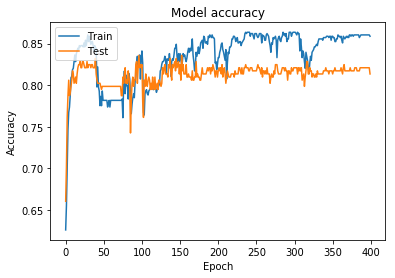

In [61]:
plt.plot(nn2_history.history['acc'])
plt.plot(nn2_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

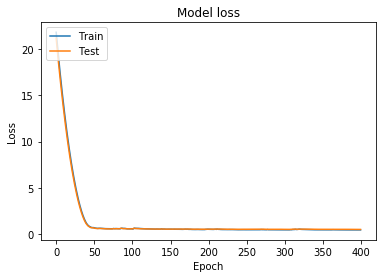

In [62]:
# Plot training & validation loss values
plt.plot(nn2_history.history['loss'])
plt.plot(nn2_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [66]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',  
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoostAUC', 'CatBoostACC', 'NeuralNetwork' ],
    'Score': [
        acc_cv_test_KNN, 
        acc_cv_test_lr,       
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost_AUC,
        acc_cv_catboost_ACC,
        NNValidationACC
        
        
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,CatBoostAUC,86.828786
7,CatBoostACC,82.943423
0,KNN,81.340000
8,NeuralNetwork,81.265858
5,Gradient Boosting Trees,79.480000
1,Logistic Regression,79.100000
3,Linear SVC,78.730000
4,Decision Tree,77.240000
2,Stochastic Gradient Decent,69.030000


In [71]:
test_encode_one_hot_cols.head()
columns_to_keep = test_encode_one_hot_cols.columns
test_data = test_encode_one_hot_cols[columns_to_keep]

test_data['Cabin_7'] = 0

In [72]:
test_data.isnull().sum()

Pclass_1    0
Pclass_2    0
Pclass_3    0
Sex_0       0
Sex_1       0
Age_0       0
Age_1       0
Age_2       0
Age_3       0
Age_4       0
Age_5       0
Age_6       0
SibSp_0     0
SibSp_1     0
SibSp_2     0
SibSp_3     0
SibSp_4     0
SibSp_5     0
SibSp_8     0
Parch_0     0
Parch_1     0
Parch_2     0
Parch_3     0
Parch_4     0
Parch_5     0
Parch_6     0
Parch_9     0
Fare_0      0
Fare_1      0
Fare_2      0
Fare_3      0
Fare_4      0
Cabin_0     0
Cabin_1     0
Cabin_2     0
Cabin_3     0
Cabin_4     0
Cabin_5     0
Cabin_6     0
Cabin_7     0
dtype: int64

In [73]:
X_test.head()
columns_to_keep= X_test.drop(columns='Cabin_7')
# # columns_to_keep.drop(columns='Cabin_7')
columns_to_keep = columns_to_keep.columns
columns_to_keep

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1', 'Age_0', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Cabin_0', 'Cabin_1',
       'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6'],
      dtype='object')

In [84]:
X_test.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1', 'Age_0', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Cabin_0', 'Cabin_1',
       'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6', 'Cabin_7'],
      dtype='object')

In [90]:
# test_data = test_data.drop(columns='Parch_9')
test_data.columns
# test_data.shape

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1', 'Age_0', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Cabin_0', 'Cabin_1',
       'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6', 'Cabin_7'],
      dtype='object')

In [76]:
# predictions = catboost_modelAUC.predict(test_data)
# # rounded = [round(x[0]) for x in predictions]
# y_predict1 = np.array(predictions,dtype='int64')
# # y_predict1

# submission = pd.DataFrame({
#         "PassengerId": test_encode["PassengerId"],
#         "Survived": y_predict1  })

# submission.to_csv('catboost_modelAUC.csv', index=False)

In [97]:
# predictions = model.predict(test_data)
# rounded = [round(x[0]) for x in predictions]
y_predict1 = np.array(predictions,dtype='int64')
# y_predict1


# submission = pd.DataFrame({
#         "PassengerId": test_encode["PassengerId"],
#         "Survived": y_predict1  })

# submission.to_csv('catboost_modelAUC.csv', index=False)

rfc_prediction = model.predict(test_data)
# X_test
rounded = [round(x[0]) for x in rfc_prediction]
y_predict1 = np.array(rounded,dtype='int64')
    
submission = pd.DataFrame({
        "PassengerId": test_encode["PassengerId"],
        "Survived": y_predict1
    })
submission.to_csv('NNMODEL.csv', index=False)